<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/). 
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA). 
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [41]:
# Imports
import torch
from torch import nn
import matplotlib.pyplot as plt
import random

## 1. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [42]:
import torchvision
from torchvision.transforms import ToTensor
# Training data from MNIST
train_data = torchvision.datasets.MNIST(root="data",
                                        train=True,
                                        download=True,
                                        transform=ToTensor()
                                         )
#  Test data from MNIST
test_data = torchvision.datasets.MNIST(root="data",
                                      train=False,
                                      download=True,
                                      transform=ToTensor())

## 6. Visualize at least 5 different samples of the MNIST training dataset.

torch.Size([1, 28, 28])


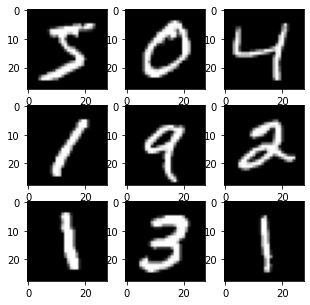

In [43]:
plt.figure(figsize=(5,5))

for i in range(9):
  image, label = train_data[i]

  plt.subplot(3, 3, i+1)
  plt.imshow(image.squeeze(), cmap="gray")

print(image.shape)

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [44]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [45]:
class TinyVGG(nn.Module):
  """Implements a convnet with the TinyVGG architecture"""
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()

    self.conv_layer = nn.Conv2d(in_channels=hidden_units,
                                out_channels=hidden_units,
                                kernel_size=3,
                                padding=1)

    self.first_block = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1),
        nn.ReLU(),
        self.conv_layer,
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.second_block = nn.Sequential(
        self.conv_layer,
        nn.ReLU(),
        self.conv_layer,
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*49, out_features=output_shape)
    )

  def forward(self, x):
    """Runs forward propagation on the input tensor x"""
    x = self.first_block(x)
    x = self.second_block(x)
    x = self.classifier(x)
    return x

tiny_vgg = TinyVGG(input_shape=1, hidden_units=3, output_shape=10)
tiny_vgg

TinyVGG(
  (conv_layer): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (first_block): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (second_block): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=147, out_features=10, bias=True)
  )
)

## 9. Define training and test loops


In [46]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn):
  train_loss, train_acc = 0, 0 # Loss and accuracy initialized to zero

  for batch, (X, y) in enumerate(data_loader):

    y_pred = model(X) # Forward step

    loss = loss_fn(y_pred, y) # Calculate loss
    train_loss += loss
    # Logits -> predicted labels
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad() # Zero the optimizer gradients

    loss.backward() # Backpropagation step

    optimizer.step() # Update weights using optimizer

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Training loss: {train_loss:.3f}, Training accuracy:{train_acc:.3f}%")

def test_step(model, data_loader, loss_fn, accuracy_fn):
  test_loss, test_acc = 0, 0

  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:
      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss: {test_loss:.3f} | Test accuracy: {test_acc:.2f}%")




## 10. Define optimizer, loss function, accuracy function, and train the model for 5 epochs

In [47]:
from tqdm.auto import tqdm

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=tiny_vgg.parameters())

def accuracy_fn(y_true, y_pred):
  return 100*torch.sum(y_pred == y_true)/len(y_pred)

EPOCHS = 3

for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch+1}\n-------")

  train_step(data_loader=train_loader,
             model=tiny_vgg,
             loss_fn=loss_fn,
             optimizer=optim,
             accuracy_fn=accuracy_fn)
  
  test_step(data_loader=test_loader,
            model=tiny_vgg,
            loss_fn=loss_fn, 
            accuracy_fn=accuracy_fn)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-------
Training loss: 0.453, Training accuracy:85.717%
Test loss: 0.181 | Test accuracy: 94.54%
Epoch: 1
-------
Training loss: 0.166, Training accuracy:94.928%
Test loss: 0.126 | Test accuracy: 95.97%
Epoch: 2
-------
Training loss: 0.138, Training accuracy:95.713%
Test loss: 0.126 | Test accuracy: 96.10%
Epoch: 3
-------
Training loss: 0.124, Training accuracy:96.225%
Test loss: 0.136 | Test accuracy: 95.83%
Epoch: 4
-------
Training loss: 0.114, Training accuracy:96.432%
Test loss: 0.105 | Test accuracy: 96.76%


## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

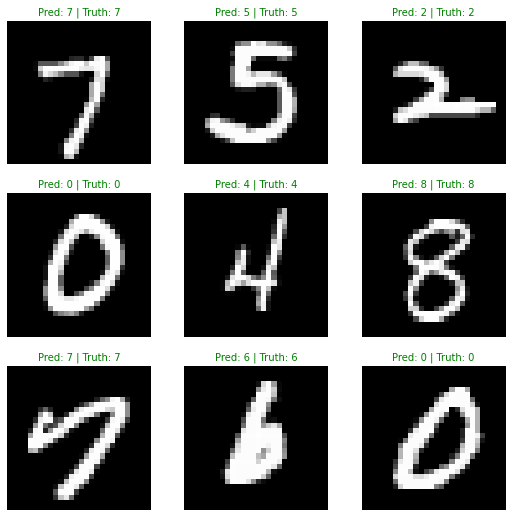

In [48]:
def make_predictions(model, data):
  """Returns predicted classes for test data using a trained model"""
  preds = []
  model.eval()

  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0)

      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      pred = pred_prob.argmax(dim=0)

      preds.append(pred)
  
  return preds

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

pred_classes = make_predictions(tiny_vgg, test_samples)

plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  pred_label = pred_classes[i]

  truth_label = test_labels[i]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);
      

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

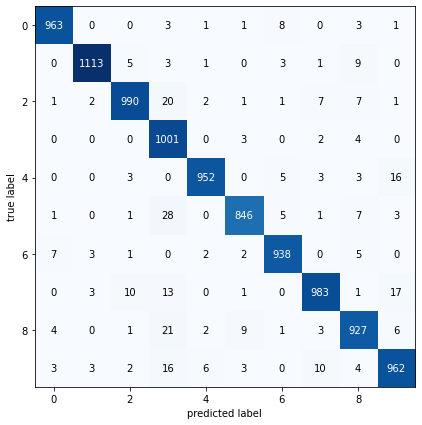

In [49]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 1. Make predictions with trained model
y_preds = []
tiny_vgg.eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc="Making predictions"):
    # Do the forward pass
    y_logit = tiny_vgg(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

confusion = ConfusionMatrix(num_classes=10, task="multiclass")

confmat = confusion(preds=y_pred_tensor, target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat.numpy(), # matplotlib likes working with NumPy
    figsize=(10, 7)
);


## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset. 
* Then plot some predictions where the model was wrong alongside what the label of the image should've been. 
* After visualing these predictions do you think it's more of a modelling error or a data error? 
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?